In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../../")

In [3]:
import jaxquantum as jqt
from jax import jit, grad
from jax.experimental.ode import odeint
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
import seaborn as sns
import qutip as qt

# Apply the default theme
sns.set_theme()

In [44]:
omega_q = 5 #GHz
omega_r = 7 #GHz
Delta = jnp.abs(omega_r - omega_q)
g = 0.1 #GHz
N = 10

a = jqt.destroy(N)
a_dag = jqt.dag(a)
Iq = jqt.identity(2)
Icav = jqt.identity(N)

# JC 
H0_JC = omega_q/2*jqt.tensor(jqt.sigmaz(), Icav)\
    + omega_r*(jqt.tensor(Iq, a_dag @ a))\# + jqt.tensor(Iq, 0.5*Icav))\
    + g*(jqt.tensor(jqt.sigmap(),a)\
    + jqt.tensor(jqt.sigmam(),a_dag)) 

# qubit drive
H1_d = jqt.tensor(jqt.sigmax(), Icav)

# meas
M = jqt.tensor(jqt.sigmaz(), Icav)

c_ops = jnp.array([])

cav_init = jqt.basis(N,0)
p_init = jqt.ket2dm(jqt.tensor(jqt.basis(2,0), cav_init)) + 0j
                       
@jit
def pi_shift_exp(omega_d):    
    t_list = jnp.linspace(0,jnp.pi,101)
    def H_func(rho, t, H0_val, H1_val, c_ops_val):
        fac = jnp.cos((omega_d+0j)*t)
        H = H0_val + H1_val*fac
        rho_dot = -1j * (H @ rho)
        rho_dot += -1j * (-rho @ H)
        return rho_dot
    
    states = odeint(H_func, p_init, t_list, H0_JC, H1_d, c_ops)
    final_state = states[-1]
    return jnp.real(jnp.trace(final_state @ M))

In [52]:
g**2/Delta

DeviceArray(0.005, dtype=float64, weak_type=True)

In [51]:
pi_shift_exp(4.952- g**2/Delta)

DeviceArray(-0.99069129, dtype=float64)

# Optimization

In [49]:
from jax.example_libraries.optimizers import adam
from jax import jit, value_and_grad

step_size = 2e-3
epochs = 100
opt_init, opt_update, get_params = adam(step_size)

@jit
def cost(x):
    return pi_shift_exp(x)

@jit
def update(x, opt_state):
    value, grads = value_and_grad(cost)(x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

def run_training(opt_state, num_print = epochs//10):
        x = get_params(opt_state)
        log = {"cost":[], "time":[]}
        log["cost"].append(cost(x))

        for epoch in range(epochs):
            start_time = time.time()
            x, opt_state, loss_val = update(x, opt_state)
            log["cost"].append(loss_val)
            log["time"].append(time.time() - start_time)
            if epoch % num_print == 0:
                print("=" * 20)
                print("Epoch: ", epoch)
                print("Time: ", log["time"][-1])
                print("Cost: ", log["cost"][-1])
                print("omega_d: ", get_params(opt_state))
        return log, opt_state

In [55]:
opt_state = opt_init(5.1)
log, opt_state = run_training(opt_state)
omega_d_opt = get_params(opt_state)

Epoch:  0
Time:  0.15327000617980957
Cost:  -0.9450537500165325
omega_d:  5.0980000000392
Epoch:  10
Time:  0.14876794815063477
Cost:  -0.9615224223256174
omega_d:  5.061158259071677
Epoch:  20
Time:  0.14905881881713867
Cost:  -0.9764083712573182
omega_d:  5.022689637522197
Epoch:  30
Time:  0.1560039520263672
Cost:  -0.9850530524185563
omega_d:  4.991739327059439
Epoch:  40
Time:  0.13833403587341309
Cost:  -0.9889812749497802
omega_d:  4.969506875182825
Epoch:  50
Time:  0.1464240550994873
Cost:  -0.990347785713399
omega_d:  4.9552191947554
Epoch:  60
Time:  0.1424410343170166
Cost:  -0.9906780708283465
omega_d:  4.947194755868237
Epoch:  70
Time:  0.1367049217224121
Cost:  -0.9907164052008818
omega_d:  4.94345116703676
Epoch:  80
Time:  0.15795183181762695
Cost:  -0.9907113627173513
omega_d:  4.94221637521556
Epoch:  90
Time:  0.15561485290527344
Cost:  -0.9907106861345023
omega_d:  4.942200439674797


In [53]:
def plot_cost_vs_epoch(log):
    _, ax = plt.subplots(1, 1)
    ax.plot(log["cost"])
    ax.set_xlabel(r"${\rm step\ number}$")
    ax.set_ylabel(r"${\rm loss}$")
    ax.set_title(r"${\rm training\ history}$")
    return ax

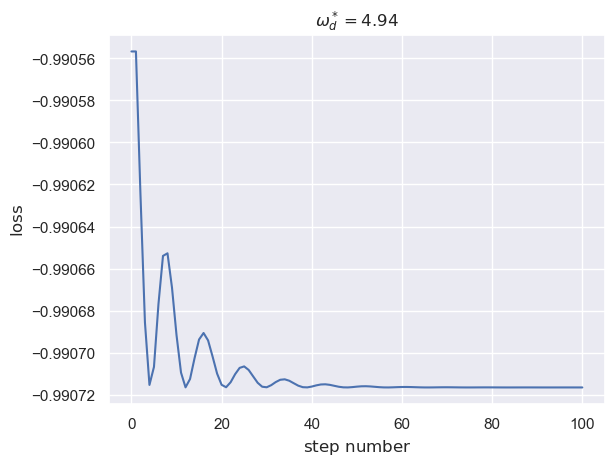

In [54]:
ax = plot_cost_vs_epoch(log)
ax.set_title(f"$\\omega_d^* = {omega_d_opt:.3}$")
plt.show()